# Image classification of cardiomyocyte tissues

This pipeline classifies cardiomyocyte images to distinguish issues from patients with chronic heart failure from ones from health donnors. It builds an image classifier using a `tf.keras.Sequential` model and load data using `tf.keras.preprocessing.image.ImageDataGenerator`. The images downloaded from https://idr.openmicroscopy.org/webclient/?show=project-402 processed with the following:

* Building _data input pipelines_ using the `tf.keras.preprocessing.image.ImageDataGenerator` class to efficiently work with data on disk to use with the model.
* _Overfitting_ —How to identify and prevent it.
* _Data augmentation_ and _dropout_ —Key techniques to fight overfitting in computer vision tasks to incorporate into the data pipeline and image classifier model.

This pipeline follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import packages

It is always a good idea to import packages separately to minimise their impact on compatibility.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

Import Tensorflow and the Keras classes needed to construct our model.

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

## Load data

Download the dataset idr0042 with the OMERO 5.6.1 JSON API https://docs.openmicroscopy.org/omero/5.6.1/developers/json-api.html. The dataset is stored in the "/tmp/" directory for training and verification.

In [4]:
################################
# Create a session to access IDR
################################
import requests


def get_session() -> requests.Session:
    IDR_BASE_URL = "https://idr.openmicroscopy.org"
    INDEX_PAGE = "%s/webclient/?experimenter=-1" % IDR_BASE_URL

    # create http session
    with requests.Session() as session:
        request = requests.Request('GET', INDEX_PAGE)
        prepped = session.prepare_request(request)
        response = session.send(prepped)
        if response.status_code != 200:
            response.raise_for_status()
    return session

In [5]:
######################
# Access test data set
######################
# import json
# from IPython.display import display, HTML
import os
import tensorflow as tf

OUTPUT_PATH = '/tmp'


def download_img(ds_id: str, session: requests.Session, output_path: str = OUTPUT_PATH):
    IDR_BASE_URL = "https://idr.openmicroscopy.org"
    DS_IMG_URI = "{base}/api/v0/m/datasets/{dataset_id}/images/?limit=2500"         # test 1155, training 1144
    IMG_RDR_URI = "{base}/webgateway/render_image/{image_id}/0/0/"
    IMG_ANNO_URI = "{base}/webclient/api/annotations/?type=map&{type}={image_id}"

    qs_ds = {'base': IDR_BASE_URL, 'dataset_id': ds_id}
    r = session.get(DS_IMG_URI.format(**qs_ds))
    # print('HTTP status for image:', r.status_code)
    if r.status_code == 200:
        #     print (json.dumps(r.json()['data'][:1], indent=2, sort_keys=True))
        for img in r.json()['data']:    # [:2]:
            img_name = img['Name']
            img_id = img['@id']
            img_path = ''

            qs_img = {'base': IDR_BASE_URL, 'image_id': img_id}
            # display(HTML("<img src='%s' />" % IMG_RDR_URI.format(**qs_img)))

            qs_anno = {'base': IDR_BASE_URL, 'type': 'image', 'image_id': img_id}
            r_anno = session.get(IMG_ANNO_URI.format(**qs_anno))
            # print('HTTP status for annotation:', r_anno.status_code)
            for a in r_anno.json()['annotations']:
                for v in a['values']:
                    key = v[0]
                    value = v[1]
                    print(key, ':', value)

                    if key == 'Diagnosis' and value != 'heart tissue pathology':
                        path = os.path.join(output_path, value.replace(" ", "_"))
                        if not os.path.exists(path):
                            os.system("mkdir -p " + path)
                        img_path = tf.keras.utils.get_file(fname=os.path.join(path, img_name), origin=IMG_RDR_URI.format(**qs_img))
            print(img_name, img_id, img_path)
            print('')       # pretty print
    return output_path


# dataset IDs
DS_TEST_ID = "827"
DS_TRAIN_ID = "828"

validation_dir: str = download_img(ds_id=DS_TEST_ID, session=get_session(), output_path=os.path.join(OUTPUT_PATH, 'validation'))
train_dir: str = download_img(ds_id=DS_TRAIN_ID, session=get_session(), output_path=os.path.join(OUTPUT_PATH, 'train'))

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
24576/24211 [==============================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 47 years
Individual : 33375
Clinical History : non-ischemic cardiomyopathy
33375_0_fal_1_0.png 3428066 /tmp/validation/chronic_heart_failure/33375_0_fal_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
24576/22656 [================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 47 years
Individual : 33375
Clinical History : non-ischemic cardiomyopathy
33375_0_fal_20_0.png 3428067 /tmp/validation/chronic_heart_failure/33375_0_fal_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
24576/24049 [==============================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : m

Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 46 years
Individual : 33380
Clinical History : ischemic cardiomyopathy
33380_0_fal_34_0.png 3428082 /tmp/validation/chronic_heart_failure/33380_0_fal_34_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/26427 [=====================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 46 years
Individual : 33380
Clinical History : ischemic cardiomyopathy
33380_0_fal_4_0.png 3428085 /tmp/validation/chronic_heart_failure/33380_0_fal_4_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
24576/22973 [================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 46 years
Individual : 33380
Clinical History : ischemic cardiomyopathy
33380_0_fal_

32768/28730 [==================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 66 years
Individual : 33389
Clinical History : ischemic cardiomyopathy
33389_0_fal_12_0.png 3428099 /tmp/validation/chronic_heart_failure/33389_0_fal_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
24576/24512 [==============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 66 years
Individual : 33389
Clinical History : ischemic cardiomyopathy
33389_0_fal_13_0.png 3428100 /tmp/validation/chronic_heart_failure/33389_0_fal_13_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/29600 [=================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 66 years
Individual : 33

32768/31571 [===============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 62 years
Individual : 33394
Clinical History : ischemic cardiomyopathy
33394_0_fal_38_0.png 3428116 /tmp/validation/chronic_heart_failure/33394_0_fal_38_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/31338 [===============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 62 years
Individual : 33394
Clinical History : ischemic cardiomyopathy
33394_0_fal_40_0.png 3428117 /tmp/validation/chronic_heart_failure/33394_0_fal_40_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/29899 [================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 62 yea

32768/26726 [====================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 64 years
Individual : 33400
Clinical History : ischemic cardiomyopathy
33400_0_fal_12_0.png 3428132 /tmp/validation/chronic_heart_failure/33400_0_fal_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/29638 [=================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 64 years
Individual : 33400
Clinical History : ischemic cardiomyopathy
33400_0_fal_14_0.png 3428133 /tmp/validation/chronic_heart_failure/33400_0_fal_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/28614 [==================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age

40960/34271 [===================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 52 years
Individual : 33401
Clinical History : ischemic cardiomyopathy
33401_0_fal_3_0.png 3428152 /tmp/validation/chronic_heart_failure/33401_0_fal_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/26430 [=====================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 52 years
Individual : 33401
Clinical History : ischemic cardiomyopathy
33401_0_fal_32_0.png 3428150 /tmp/validation/chronic_heart_failure/33401_0_fal_32_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/29470 [=================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 52 years
Individua

24576/22339 [=================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 33406
Clinical History : ischemic cardiomyopathy
33406_0_fal_17_0.png 3428165 /tmp/validation/chronic_heart_failure/33406_0_fal_17_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
24576/22716 [================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 33406
Clinical History : ischemic cardiomyopathy
33406_0_fal_2_0.png 3428169 /tmp/validation/chronic_heart_failure/33406_0_fal_2_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
24576/23516 [===============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 33406

32768/30805 [===============================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33407
Clinical History : non-ischemic cardiomyopathy
33407_0_fal_3_0.png 3428183 /tmp/validation/chronic_heart_failure/33407_0_fal_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/27337 [===================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33407
Clinical History : non-ischemic cardiomyopathy
33407_0_fal_4_0.png 3428185 /tmp/validation/chronic_heart_failure/33407_0_fal_4_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/30891 [===============================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33407
Clinical History : 

32768/25409 [======================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 33409
Clinical History : ischemic cardiomyopathy
33409_0_fal_17_0.png 3428200 /tmp/validation/chronic_heart_failure/33409_0_fal_17_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/26886 [====================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 33409
Clinical History : ischemic cardiomyopathy
33409_0_fal_19_0.png 3428201 /tmp/validation/chronic_heart_failure/33409_0_fal_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/26051 [=====================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
I

32768/24946 [=======================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 60 years
Individual : 33414
Clinical History : ischemic cardiomyopathy
33414_0_fal_39_0.png 3428216 /tmp/validation/chronic_heart_failure/33414_0_fal_39_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/30856 [===============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 60 years
Individual : 33414
Clinical History : ischemic cardiomyopathy
33414_0_fal_40_0.png 3428218 /tmp/validation/chronic_heart_failure/33414_0_fal_40_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/26901 [====================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American


Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 58 years
Individual : 33417
Clinical History : non-ischemic cardiomyopathy
33417_0_fal_22_0.png 3428233 /tmp/validation/chronic_heart_failure/33417_0_fal_22_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
24576/23554 [===============================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 58 years
Individual : 33417
Clinical History : non-ischemic cardiomyopathy
33417_0_fal_24_0.png 3428234 /tmp/validation/chronic_heart_failure/33417_0_fal_24_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/28361 [==================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 58 years
Individual : 33417
Clinical History : non-ischemic cardi

32768/26120 [=====================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 61 years
Individual : 33420
Clinical History : ischemic cardiomyopathy
33420_0_fal_45_0.png 3428250 /tmp/validation/chronic_heart_failure/33420_0_fal_45_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/27248 [====================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 61 years
Individual : 33420
Clinical History : ischemic cardiomyopathy
33420_0_fal_49_0.png 3428251 /tmp/validation/chronic_heart_failure/33420_0_fal_49_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
40960/33920 [====================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/27798 [===================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 64 years
Individual : 33424
Clinical History : ischemic cardiomyopathy
33424_0_fal_20_0.png 3428267 /tmp/validation/chronic_heart_failure/33424_0_fal_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/25933 [=====================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 64 years
Individual : 33424
Clinical History : ischemic cardiomyopathy
33424_0_fal_28_0.png 3428268 /tmp/validation/chronic_heart_failure/33424_0_fal_28_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/29870 [================================] - 0s

40960/34562 [===================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 33466
Clinical History : ischemic cardiomyopathy
33466_0_fal_3_0.png 3428283 /tmp/validation/chronic_heart_failure/33466_0_fal_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
24576/23692 [===============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 33466
Clinical History : ischemic cardiomyopathy
33466_0_fal_46_0.png 3428284 /tmp/validation/chronic_heart_failure/33466_0_fal_46_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/28146 [==================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 3

32768/27321 [===================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 41 years
Individual : 33468
Clinical History : ischemic cardiomyopathy
33468_0_fal_27_0.png 3428300 /tmp/validation/chronic_heart_failure/33468_0_fal_27_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
24576/23792 [==============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 41 years
Individual : 33468
Clinical History : ischemic cardiomyopathy
33468_0_fal_30_0.png 3428301 /tmp/validation/chronic_heart_failure/33468_0_fal_30_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/25521 [======================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknow

40960/33740 [====================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 57 years
Individual : 33472
Clinical History : non-ischemic cardiomyopathy
33472_0_fal_50_0.png 3428317 /tmp/validation/chronic_heart_failure/33472_0_fal_50_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/27604 [===================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 57 years
Individual : 33472
Clinical History : non-ischemic cardiomyopathy
33472_0_fal_8_0.png 3428318 /tmp/validation/chronic_heart_failure/33472_0_fal_8_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
24576/23080 [===============================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 63 years
Individual : 33476
Clini

40960/35643 [==================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 28 years
Individual : 33477
Clinical History : non-ischemic cardiomyopathy
33477_0_fal_3_0.png 3428334 /tmp/validation/chronic_heart_failure/33477_0_fal_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/27138 [====================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 28 years
Individual : 33477
Clinical History : non-ischemic cardiomyopathy
33477_0_fal_41_0.png 3428335 /tmp/validation/chronic_heart_failure/33477_0_fal_41_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/31265 [===============================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 28 years
Individual : 33477
Clinical Hist

40960/34534 [===================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 33480
Clinical History : ischemic cardiomyopathy
33480_0_fal_19_0.png 3428350 /tmp/validation/chronic_heart_failure/33480_0_fal_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/27463 [===================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 68 years
Individual : 33482
Clinical History : ischemic cardiomyopathy
33482_0_fal_10_0.png 3428352 /tmp/validation/chronic_heart_failure/33482_0_fal_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/31952 [==============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 68 year

32768/30898 [===============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 64 years
Individual : 33484
Clinical History : ischemic cardiomyopathy
33484_0_fal_35_0.png 3428368 /tmp/validation/chronic_heart_failure/33484_0_fal_35_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/29475 [=================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 64 years
Individual : 33484
Clinical History : ischemic cardiomyopathy
33484_0_fal_40_0.png 3428369 /tmp/validation/chronic_heart_failure/33484_0_fal_40_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/28464 [==================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 64 years
Individual : 3

32768/32013 [==============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 62 years
Individual : 33537
Clinical History : ischemic cardiomyopathy
33537_0_fal_1_0.png 3428389 /tmp/validation/chronic_heart_failure/33537_0_fal_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
40960/35621 [==================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 62 years
Individual : 33537
Clinical History : ischemic cardiomyopathy
33537_0_fal_11_0.png 3428385 /tmp/validation/chronic_heart_failure/33537_0_fal_11_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/32124 [==============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 62 years

32768/32127 [==============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 68 years
Individual : 33538
Clinical History : ischemic cardiomyopathy
33538_0_fal_21_0.png 3428400 /tmp/validation/chronic_heart_failure/33538_0_fal_21_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/30606 [================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 68 years
Individual : 33538
Clinical History : ischemic cardiomyopathy
33538_0_fal_22_0.png 3428401 /tmp/validation/chronic_heart_failure/33538_0_fal_22_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/28182 [==================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racia

32768/27679 [===================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 57 years
Individual : 33542
Clinical History : non-ischemic cardiomyopathy
33542_0_fal_10_0.png 3428418 /tmp/validation/chronic_heart_failure/33542_0_fal_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/30133 [================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 57 years
Individual : 33542
Clinical History : non-ischemic cardiomyopathy
33542_0_fal_1_0.png 3428426 /tmp/validation/chronic_heart_failure/33542_0_fal_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/29138 [=================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 57 years
Individual :

32768/30335 [================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 33545
Clinical History : ischemic cardiomyopathy
33545_0_fal_41_0.png 3428435 /tmp/validation/chronic_heart_failure/33545_0_fal_41_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/29115 [=================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 33545
Clinical History : ischemic cardiomyopathy
33545_0_fal_44_0.png 3428436 /tmp/validation/chronic_heart_failure/33545_0_fal_44_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/29324 [=================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 3

32768/30240 [================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 31 years
Individual : 33548
Clinical History : non-ischemic cardiomyopathy
33548_0_fal_15_0.png 3428452 /tmp/validation/chronic_heart_failure/33548_0_fal_15_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/31027 [===============================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 31 years
Individual : 33548
Clinical History : non-ischemic cardiomyopathy
33548_0_fal_17_0.png 3428453 /tmp/validation/chronic_heart_failure/33548_0_fal_17_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/30313 [================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 31 yea

32768/28576 [==================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Individual : 33549
Clinical History : non-ischemic cardiomyopathy
33549_0_fal_44_0.png 3428469 /tmp/validation/chronic_heart_failure/33549_0_fal_44_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
24576/18325 [========================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Individual : 33549
Clinical History : non-ischemic cardiomyopathy
33549_0_fal_49_0.png 3428470 /tmp/validation/chronic_heart_failure/33549_0_fal_49_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/30552 [================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Individual : 33549
Clinical History : non-ischemic cardiomyopathy
3354

32768/25772 [======================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 34072
Clinical History : normal cardiovascular function by cardiac catheterization
34072_1_nrm_14_0.png 3428486 /tmp/validation/not_chronic_heart_failure/34072_1_nrm_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/25467 [======================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 34072
Clinical History : normal cardiovascular function by cardiac catheterization
34072_1_nrm_16_0.png 3428487 /tmp/validation/not_chronic_heart_failure/34072_1_nrm_16_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
40960/33501 [====================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 34072
Clinical History : norm

32768/27656 [===================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 62 years
Individual : 34073
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34073_1_nrm_16_0.png 3428501 /tmp/validation/not_chronic_heart_failure/34073_1_nrm_16_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/27906 [===================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 62 years
Individual : 34073
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34073_1_nrm_17_0.png 3428502 /tmp/validation/not_chronic_heart_failure/34073_1_nrm_17_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/31091 [===========================

32768/28976 [=================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 19 years
Individual : 34076
Clinical History : non-ischemic cardiomyopathy
34076_0_fal_16_0.png 3428518 /tmp/validation/chronic_heart_failure/34076_0_fal_16_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/32112 [==============================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 19 years
Individual : 34076
Clinical History : non-ischemic cardiomyopathy
34076_0_fal_22_0.png 3428519 /tmp/validation/chronic_heart_failure/34076_0_fal_22_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
40960/33372 [====================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 19 years
Individual : 34076
Clinical Hist

32768/28202 [==================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 51 years
Individual : 34077
Clinical History : non-ischemic cardiomyopathy
34077_0_fal_41_0.png 3428534 /tmp/validation/chronic_heart_failure/34077_0_fal_41_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/31355 [===============================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 51 years
Individual : 34077
Clinical History : non-ischemic cardiomyopathy
34077_0_fal_43_0.png 3428535 /tmp/validation/chronic_heart_failure/34077_0_fal_43_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/29490 [=================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 51 years
Individual : 34077
Clinical Histo

32768/31538 [===============================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 34085
Clinical History : non-ischemic cardiomyopathy
34085_0_fal_20_0.png 3428552 /tmp/validation/chronic_heart_failure/34085_0_fal_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/31561 [===============================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 34085
Clinical History : non-ischemic cardiomyopathy
34085_0_fal_24_0.png 3428553 /tmp/validation/chronic_heart_failure/34085_0_fal_24_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/28876 [==================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 34085
Clinical History

32768/27430 [===================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 54 years
Individual : 34086
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34086_1_nrm_19_0.png 3428567 /tmp/validation/not_chronic_heart_failure/34086_1_nrm_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/26233 [=====================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 54 years
Individual : 34086
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34086_1_nrm_2_0.png 3428571 /tmp/validation/not_chronic_heart_failure/34086_1_nrm_2_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/28082 [===================================] - 0s 0us/ste

32768/29677 [=================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Caucasian
Age : 48 years
Individual : 34089
Clinical History : non-ischemic cardiomyopathy
34089_0_fal_18_0.png 3428588 /tmp/validation/chronic_heart_failure/34089_0_fal_18_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/29672 [=================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Caucasian
Age : 48 years
Individual : 34089
Clinical History : non-ischemic cardiomyopathy
34089_0_fal_19_0.png 3428589 /tmp/validation/chronic_heart_failure/34089_0_fal_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/27629 [===================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Caucasian
Age : 48 years
Individual : 34089
Clini

40960/34508 [===================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 34090
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34090_1_nrm_23_0.png 3428604 /tmp/validation/not_chronic_heart_failure/34090_1_nrm_23_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : heart tissue pathology
Disease Subtype : myocardium disease
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 34092
Clinical History : donor without a history of chronic symptomatic heart failure but tissue pathology
34092_1_nrm_10_0.png 3428605 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : heart tissue pathology
Disease Subtype : myocardium disease
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 34092
Clinical History : donor without a history of chronic symptomatic heart 

32768/24968 [=======================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Race not stated
Age : 61 years
Individual : 34231
Clinical History : non-ischemic cardiomyopathy
34231_0_fal_26_0.png 3428623 /tmp/validation/chronic_heart_failure/34231_0_fal_26_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/24811 [=======================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Race not stated
Age : 61 years
Individual : 34231
Clinical History : non-ischemic cardiomyopathy
34231_0_fal_27_0.png 3428624 /tmp/validation/chronic_heart_failure/34231_0_fal_27_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/27552 [===================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Race not stated
Age : 61 

24576/24199 [==============================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 34281
Clinical History : no documentation of ischemic vs non-ischemic etiology
34281_0_fal_14_0.png 3428640 /tmp/validation/chronic_heart_failure/34281_0_fal_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/26879 [====================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 34281
Clinical History : no documentation of ischemic vs non-ischemic etiology
34281_0_fal_15_0.png 3428641 /tmp/validation/chronic_heart_failure/34281_0_fal_15_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/29401 [=================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 34281
Clinical History : no documentation of ischemic vs non-ische

32768/30547 [================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 34296
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34296_1_nrm_5_0.png 3428657 /tmp/validation/not_chronic_heart_failure/34296_1_nrm_5_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/31890 [==============================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 34296
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34296_1_nrm_6_0.png 3428658 /tmp/validation/not_chronic_heart_failure/34296_1_nrm_6_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/30661 [================================] - 0s 0us/step
Sex : female


32768/26007 [=====================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 71 years
Individual : 35590
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35590_1_nrm_25_0.png 3428673 /tmp/validation/not_chronic_heart_failure/35590_1_nrm_25_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/30359 [================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 71 years
Individual : 35590
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35590_1_nrm_27_0.png 3428674 /tmp/validation/not_chronic_heart_failure/35590_1_nrm_27_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/31686 [===============================] - 0s 0us/step
Sex : m

32768/26056 [=====================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Hispanic
Age : 69 years
Individual : 35592
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35592_1_nrm_38_0.png 3428687 /tmp/validation/not_chronic_heart_failure/35592_1_nrm_38_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/30080 [================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Hispanic
Age : 69 years
Individual : 35592
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35592_1_nrm_42_0.png 3428689 /tmp/validation/not_chronic_heart_failure/35592_1_nrm_42_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/27294 [====================================] - 0s 0us/step


32768/26252 [=====================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : African American
Age : 73 years
Individual : 35597
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35597_1_nrm_10_0.png 3428704 /tmp/validation/not_chronic_heart_failure/35597_1_nrm_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/27930 [===================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : African American
Age : 73 years
Individual : 35597
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35597_1_nrm_11_0.png 3428705 /tmp/validation/not_chronic_heart_failure/35597_1_nrm_11_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/28209 [=================================

32768/27958 [===================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 51 years
Individual : 35599
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35599_1_nrm_33_0.png 3428719 /tmp/validation/not_chronic_heart_failure/35599_1_nrm_33_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/22973 [================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 51 years
Individual : 35599
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35599_1_nrm_34_0.png 3428720 /tmp/validation/not_chronic_heart_failure/35599_1_nrm_34_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/22400 [================================] - 0s 0us/step
Sex 

24576/23533 [===============================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : African American
Age : 53 years
Individual : 35601
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35601_1_nrm_42_0.png 3428734 /tmp/validation/not_chronic_heart_failure/35601_1_nrm_42_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/24521 [==============================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : African American
Age : 53 years
Individual : 35601
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35601_1_nrm_45_0.png 3428735 /tmp/validation/not_chronic_heart_failure/35601_1_nrm_45_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/21776 [=================================] - 0s 0us/step

24576/24067 [==============================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 35603
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35603_1_nrm_1_0.png 3428752 /tmp/validation/not_chronic_heart_failure/35603_1_nrm_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/22833 [================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 35603
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35603_1_nrm_12_0.png 3428749 /tmp/validation/not_chronic_heart_failure/35603_1_nrm_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/22751 [================================] - 0s 0us/step
Sex : femal

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/25745 [======================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Hispanic
Age : 44 years
Individual : 35606
Clinical History : normal cardiovascular function by cardiac catheterization
35606_1_nrm_22_0.png 3428765 /tmp/validation/not_chronic_heart_failure/35606_1_nrm_22_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/24216 [==============================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Hispanic
Age : 44 years
Individual : 35606
Clinical History : normal cardiovascular function by cardiac catheterization
35606_1_nrm_31_0.png 3428766 /tmp/validation/not_chronic_heart_failure/35606_1_nrm_31_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/30646 [================================] - 0s 0us/step
Sex : male
Ethnic 

32768/30248 [================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : African American
Age : 20 years
Individual : 35609
Clinical History : normal cardiovascular function by cardiac catheterization
35609_1_nrm_10_0.png 3428781 /tmp/validation/not_chronic_heart_failure/35609_1_nrm_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/24753 [=======================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : African American
Age : 20 years
Individual : 35609
Clinical History : normal cardiovascular function by cardiac catheterization
35609_1_nrm_1_0.png 3428785 /tmp/validation/not_chronic_heart_failure/35609_1_nrm_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/23450 [===============================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : African American
Age : 20 years
Individual : 35609
Clinical

32768/30866 [===============================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 55 years
Individual : 35622
Clinical History : normal cardiovascular function by cardiac catheterization
35622_1_nrm_33_0.png 3428798 /tmp/validation/not_chronic_heart_failure/35622_1_nrm_33_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/25994 [=====================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 55 years
Individual : 35622
Clinical History : normal cardiovascular function by cardiac catheterization
35622_1_nrm_39_0.png 3428799 /tmp/validation/not_chronic_heart_failure/35622_1_nrm_39_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/26838 [====================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 55 years
Individual : 35622
Clinical History : normal

Sex : male
Ethnic or Racial Group : African American
Age : 3 years
Individual : 35625
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35625_1_nrm_44_0.png 3428813 /tmp/validation/not_chronic_heart_failure/35625_1_nrm_44_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/27395 [===================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 35626
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35626_1_nrm_10_0.png 3428814 /tmp/validation/not_chronic_heart_failure/35626_1_nrm_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/26155 [=====================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 65

24576/23544 [===============================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 43 years
Individual : 35628
Clinical History : normal cardiovascular function by cardiac catheterization
35628_1_nrm_28_0.png 3428827 /tmp/validation/not_chronic_heart_failure/35628_1_nrm_28_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/30962 [===============================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 43 years
Individual : 35628
Clinical History : normal cardiovascular function by cardiac catheterization
35628_1_nrm_30_0.png 3428829 /tmp/validation/not_chronic_heart_failure/35628_1_nrm_30_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/24166 [==============================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 43 years
Individual : 35628
Clinical History : normal cardiovascular fu

32768/27200 [====================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Hispanic
Age : 51 years
Individual : 35629
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35629_1_nrm_42_0.png 3428844 /tmp/validation/not_chronic_heart_failure/35629_1_nrm_42_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/25853 [======================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Hispanic
Age : 51 years
Individual : 35629
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35629_1_nrm_48_0.png 3428845 /tmp/validation/not_chronic_heart_failure/35629_1_nrm_48_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/22818 [================================] - 0s 0us/step
Sex

32768/27553 [===================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 35632
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35632_1_nrm_13_0.png 3428859 /tmp/validation/not_chronic_heart_failure/35632_1_nrm_13_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/26223 [=====================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 35632
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35632_1_nrm_15_0.png 3428860 /tmp/validation/not_chronic_heart_failure/35632_1_nrm_15_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/23755 [===============================] - 0s 0us/step
Sex 

32768/25687 [======================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 48 years
Individual : 35635
Clinical History : normal cardiovascular function by cardiac catheterization
35635_1_nrm_43_0.png 3428875 /tmp/validation/not_chronic_heart_failure/35635_1_nrm_43_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/26512 [=====================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 48 years
Individual : 35635
Clinical History : normal cardiovascular function by cardiac catheterization
35635_1_nrm_44_0.png 3428876 /tmp/validation/not_chronic_heart_failure/35635_1_nrm_44_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/26978 [====================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 48 years
Individual : 35635
Clinical History : norma

32768/28835 [==================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Hispanic
Age : 37 years
Individual : 35638
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35638_1_nrm_3_0.png 3428895 /tmp/validation/not_chronic_heart_failure/35638_1_nrm_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/30383 [================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Hispanic
Age : 37 years
Individual : 35638
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35638_1_nrm_34_0.png 3428892 /tmp/validation/not_chronic_heart_failure/35638_1_nrm_34_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
40960/39071 [===============================] - 0s 0us/step
Sex : fema

32768/28277 [==================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 35643
Clinical History : normal cardiovascular function by cardiac catheterization
35643_1_nrm_36_0.png 3428908 /tmp/validation/not_chronic_heart_failure/35643_1_nrm_36_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/31428 [===============================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 35643
Clinical History : normal cardiovascular function by cardiac catheterization
35643_1_nrm_42_0.png 3428909 /tmp/validation/not_chronic_heart_failure/35643_1_nrm_42_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/27673 [===================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 35643
Clinical History : normal car

32768/24653 [=======================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : African American
Age : 50 years
Individual : 35644
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35644_1_nrm_2_0.png 3428923 /tmp/validation/not_chronic_heart_failure/35644_1_nrm_2_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/27701 [===================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35646
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35646_1_nrm_10_0.png 3428924 /tmp/validation/not_chronic_heart_failure/35646_1_nrm_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/24364 [==============================] - 0s 0us/ste

24576/22357 [================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : African American
Age : 48 years
Individual : 35649
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35649_1_nrm_35_0.png 3428937 /tmp/validation/not_chronic_heart_failure/35649_1_nrm_35_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/23287 [===============================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : African American
Age : 48 years
Individual : 35649
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35649_1_nrm_36_0.png 3428938 /tmp/validation/not_chronic_heart_failure/35649_1_nrm_36_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/22250 [=================================] - 0s 0us/st

32768/25030 [=======================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : African American
Age : 50 years
Individual : 35651
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35651_1_nrm_48_0.png 3428952 /tmp/validation/not_chronic_heart_failure/35651_1_nrm_48_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/24487 [==============================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : African American
Age : 50 years
Individual : 35651
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35651_1_nrm_6_0.png 3428954 /tmp/validation/not_chronic_heart_failure/35651_1_nrm_6_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/23132 [===============================] - 0s 

32768/27438 [===================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 35880
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35880_1_nrm_10_0.png 3428968 /tmp/validation/not_chronic_heart_failure/35880_1_nrm_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/27765 [===================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 35880
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35880_1_nrm_1_0.png 3428977 /tmp/validation/not_chronic_heart_failure/35880_1_nrm_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/30597 [================================] - 0s 0us/step
Sex : m

32768/30789 [===============================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 36109
Clinical History : normal cardiovascular function by cardiac catheterization
36109_1_nrm_15_0.png 3428983 /tmp/validation/not_chronic_heart_failure/36109_1_nrm_15_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/22164 [=================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 36109
Clinical History : normal cardiovascular function by cardiac catheterization
36109_1_nrm_16_0.png 3428984 /tmp/validation/not_chronic_heart_failure/36109_1_nrm_16_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/20064 [====================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 36109
Clinical History : normal cardiovas

40960/35596 [==================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 21 years
Individual : 36114
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36114_1_nrm_9_0.png 3429000 /tmp/validation/not_chronic_heart_failure/36114_1_nrm_9_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
40960/36444 [=================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 36116
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36116_1_nrm_10_0.png 3429001 /tmp/validation/not_chronic_heart_failure/36116_1_nrm_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
40960/33890 [====================================] - 0s 0us/step
Se

32768/30691 [================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 26 years
Individual : 36117
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36117_1_nrm_15_0.png 3429015 /tmp/validation/not_chronic_heart_failure/36117_1_nrm_15_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/29516 [=================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 26 years
Individual : 36117
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36117_1_nrm_17_0.png 3429016 /tmp/validation/not_chronic_heart_failure/36117_1_nrm_17_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/28869 [==================================] - 0s 0us/step
Sex 

32768/24696 [=======================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 78 years
Individual : 36121
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36121_1_nrm_33_0.png 3429030 /tmp/validation/not_chronic_heart_failure/36121_1_nrm_33_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/28223 [==================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 78 years
Individual : 36121
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36121_1_nrm_43_0.png 3429031 /tmp/validation/not_chronic_heart_failure/36121_1_nrm_43_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/24156 [==============================] - 0s 0us/step


32768/28435 [==================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 36129
Clinical History : normal cardiovascular function by cardiac catheterization
36129_1_nrm_10_0.png 3429045 /tmp/validation/not_chronic_heart_failure/36129_1_nrm_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/29166 [=================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 36129
Clinical History : normal cardiovascular function by cardiac catheterization
36129_1_nrm_1_0.png 3429050 /tmp/validation/not_chronic_heart_failure/36129_1_nrm_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/27221 [====================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 36129
Clinical History : normal cardiova

32768/28474 [==================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 77 years
Individual : 36135
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36135_1_nrm_27_0.png 3429061 /tmp/validation/not_chronic_heart_failure/36135_1_nrm_27_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
40960/33329 [====================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 77 years
Individual : 36135
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36135_1_nrm_35_0.png 3429062 /tmp/validation/not_chronic_heart_failure/36135_1_nrm_35_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
40960/34725 [===================================] - 0s 0us/ste

32768/25796 [======================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 33382
Clinical History : ischemic cardiomyopathy
33382_0_fal_10_0.png 3429606 /tmp/train/chronic_heart_failure/33382_0_fal_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/29221 [=================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 33382
Clinical History : ischemic cardiomyopathy
33382_0_fal_1_0.png 3429608 /tmp/train/chronic_heart_failure/33382_0_fal_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/27674 [===================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 33382

24576/23099 [===============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 33383
Clinical History : ischemic cardiomyopathy
33383_0_fal_42_0.png 3429623 /tmp/train/chronic_heart_failure/33383_0_fal_42_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
24576/22410 [================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 33383
Clinical History : ischemic cardiomyopathy
33383_0_fal_45_0.png 3429624 /tmp/train/chronic_heart_failure/33383_0_fal_45_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
24576/22980 [================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 33383
Clinical

32768/27231 [====================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 65 years
Individual : 33387
Clinical History : ischemic cardiomyopathy
33387_0_fal_15_0.png 3429629 /tmp/train/chronic_heart_failure/33387_0_fal_15_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/31970 [==============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 65 years
Individual : 33387
Clinical History : ischemic cardiomyopathy
33387_0_fal_16_0.png 3429630 /tmp/train/chronic_heart_failure/33387_0_fal_16_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/28564 [==================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial grou

32768/26106 [=====================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 33392
Clinical History : ischemic cardiomyopathy
33392_0_fal_45_0.png 3429645 /tmp/train/chronic_heart_failure/33392_0_fal_45_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/27231 [====================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 33392
Clinical History : ischemic cardiomyopathy
33392_0_fal_47_0.png 3429646 /tmp/train/chronic_heart_failure/33392_0_fal_47_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/27511 [===================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 3

32768/29683 [=================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 64 years
Individual : 33396
Clinical History : ischemic cardiomyopathy
33396_0_fal_17_0.png 3429662 /tmp/train/chronic_heart_failure/33396_0_fal_17_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/29884 [================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 64 years
Individual : 33396
Clinical History : ischemic cardiomyopathy
33396_0_fal_18_0.png 3429663 /tmp/train/chronic_heart_failure/33396_0_fal_18_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/30950 [===============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 64 years
Indiv

32768/25680 [======================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 18 years
Individual : 33398
Clinical History : non-ischemic cardiomyopathy
33398_0_fal_5_0.png 3429240 /tmp/train/chronic_heart_failure/33398_0_fal_5_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/24768 [=======================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 18 years
Individual : 33398
Clinical History : non-ischemic cardiomyopathy
33398_0_fal_7_0.png 3429241 /tmp/train/chronic_heart_failure/33398_0_fal_7_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/27272 [====================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 18 years
Individual : 33398
Clinical Hist

32768/30138 [================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 19 years
Individual : 33403
Clinical History : non-ischemic cardiomyopathy
33403_0_fal_32_0.png 3429675 /tmp/train/chronic_heart_failure/33403_0_fal_32_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/27845 [===================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 19 years
Individual : 33403
Clinical History : non-ischemic cardiomyopathy
33403_0_fal_34_0.png 3429676 /tmp/train/chronic_heart_failure/33403_0_fal_34_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/29134 [=================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 19 years
Individual : 33403
Clinical History : non

32768/32560 [==============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 33410
Clinical History : ischemic cardiomyopathy
33410_0_fal_43_0.png 3429263 /tmp/train/chronic_heart_failure/33410_0_fal_43_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/29251 [=================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 33410
Clinical History : ischemic cardiomyopathy
33410_0_fal_44_0.png 3429264 /tmp/train/chronic_heart_failure/33410_0_fal_44_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/26687 [====================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 33411
Clinical Hist

32768/28479 [==================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 33412
Clinical History : ischemic cardiomyopathy
33412_0_fal_3_0.png 3429698 /tmp/train/chronic_heart_failure/33412_0_fal_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/30865 [===============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 33412
Clinical History : ischemic cardiomyopathy
33412_0_fal_42_0.png 3429699 /tmp/train/chronic_heart_failure/33412_0_fal_42_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/27292 [====================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 33412
Clin

32768/26923 [====================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 33413
Clinical History : ischemic cardiomyopathy
33413_0_fal_5_0.png 3429715 /tmp/train/chronic_heart_failure/33413_0_fal_5_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/26343 [=====================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 49 years
Individual : 33415
Clinical History : non-ischemic cardiomyopathy
33415_0_fal_10_0.png 3429716 /tmp/train/chronic_heart_failure/33415_0_fal_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/28289 [==================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 49 years
Individual : 33415
Clinical His

32768/26992 [====================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 33418
Clinical History : ischemic cardiomyopathy
33418_0_fal_30_0.png 3429732 /tmp/train/chronic_heart_failure/33418_0_fal_30_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/28843 [==================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 33418
Clinical History : ischemic cardiomyopathy
33418_0_fal_4_0.png 3429734 /tmp/train/chronic_heart_failure/33418_0_fal_4_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/31362 [===============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 33418
Clin

32768/27697 [===================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 33421
Clinical History : ischemic cardiomyopathy
33421_0_fal_11_0.png 3429265 /tmp/train/chronic_heart_failure/33421_0_fal_11_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
40960/34318 [===================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 33421
Clinical History : ischemic cardiomyopathy
33421_0_fal_15_0.png 3429266 /tmp/train/chronic_heart_failure/33421_0_fal_15_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
40960/34030 [====================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 334

24576/24152 [==============================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 53 years
Individual : 33422
Clinical History : non-ischemic cardiomyopathy
33422_0_fal_3_0.png 3429755 /tmp/train/chronic_heart_failure/33422_0_fal_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/26878 [====================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 53 years
Individual : 33422
Clinical History : non-ischemic cardiomyopathy
33422_0_fal_40_0.png 3429756 /tmp/train/chronic_heart_failure/33422_0_fal_40_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/25349 [======================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 53 years


32768/29089 [=================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 33469
Clinical History : ischemic cardiomyopathy
33469_0_fal_2_0.png 3429292 /tmp/train/chronic_heart_failure/33469_0_fal_2_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/28296 [==================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 33469
Clinical History : ischemic cardiomyopathy
33469_0_fal_24_0.png 3429287 /tmp/train/chronic_heart_failure/33469_0_fal_24_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/29880 [================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 33469
Clinic

32768/24878 [=======================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 33471
Clinical History : ischemic cardiomyopathy
33471_0_fal_18_0.png 3429765 /tmp/train/chronic_heart_failure/33471_0_fal_18_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/27196 [====================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 33471
Clinical History : ischemic cardiomyopathy
33471_0_fal_19_0.png 3429766 /tmp/train/chronic_heart_failure/33471_0_fal_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/26383 [=====================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual

32768/31454 [===============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 27 years
Individual : 33478
Clinical History : ischemic cardiomyopathy
33478_0_fal_16_0.png 3429783 /tmp/train/chronic_heart_failure/33478_0_fal_16_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/26218 [=====================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 27 years
Individual : 33478
Clinical History : ischemic cardiomyopathy
33478_0_fal_22_0.png 3429784 /tmp/train/chronic_heart_failure/33478_0_fal_22_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/32294 [==============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 27 years
Individual : 33478
Clini

32768/31295 [===============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33479
Clinical History : ischemic cardiomyopathy
33479_0_fal_38_0.png 3429800 /tmp/train/chronic_heart_failure/33479_0_fal_38_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/30565 [================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33479
Clinical History : ischemic cardiomyopathy
33479_0_fal_4_0.png 3429802 /tmp/train/chronic_heart_failure/33479_0_fal_4_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/27204 [====================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33479
Clinic

32768/29916 [================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 54 years
Individual : 33485
Clinical History : ischemic cardiomyopathy
33485_0_fal_11_0.png 3429816 /tmp/train/chronic_heart_failure/33485_0_fal_11_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/31951 [==============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 54 years
Individual : 33485
Clinical History : ischemic cardiomyopathy
33485_0_fal_12_0.png 3429817 /tmp/train/chronic_heart_failure/33485_0_fal_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/29749 [=================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 54 years
Individual : 33485
Clinical

32768/29333 [=================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 63 years
Individual : 33486
Clinical History : ischemic cardiomyopathy
33486_0_fal_44_0.png 3429834 /tmp/train/chronic_heart_failure/33486_0_fal_44_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/27595 [===================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 63 years
Individual : 33486
Clinical History : ischemic cardiomyopathy
33486_0_fal_49_0.png 3429835 /tmp/train/chronic_heart_failure/33486_0_fal_49_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
24576/24108 [==============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 63 years
Ind

32768/29904 [================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 55 years
Individual : 33489
Clinical History : ischemic cardiomyopathy
33489_0_fal_2_0.png 3429854 /tmp/train/chronic_heart_failure/33489_0_fal_2_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/30585 [================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 55 years
Individual : 33489
Clinical History : ischemic cardiomyopathy
33489_0_fal_21_0.png 3429851 /tmp/train/chronic_heart_failure/33489_0_fal_21_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/28371 [==================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 55 years
Individual : 33489
Clinica

32768/26189 [=====================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 33536
Clinical History : ischemic cardiomyopathy
33536_0_fal_40_0.png 3429868 /tmp/train/chronic_heart_failure/33536_0_fal_40_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/31688 [===============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 33536
Clinical History : ischemic cardiomyopathy
33536_0_fal_8_0.png 3429869 /tmp/train/chronic_heart_failure/33536_0_fal_8_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
40960/35173 [==================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 23 years
Individual : 33540
Clinical His

32768/30659 [================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 60 years
Individual : 33543
Clinical History : non-ischemic cardiomyopathy
33543_0_fal_27_0.png 3429874 /tmp/train/chronic_heart_failure/33543_0_fal_27_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/29294 [=================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 60 years
Individual : 33543
Clinical History : non-ischemic cardiomyopathy
33543_0_fal_28_0.png 3429875 /tmp/train/chronic_heart_failure/33543_0_fal_28_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/30808 [===============================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 60 years
Indivi

32768/32177 [==============================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 64 years
Individual : 33544
Clinical History : non-ischemic cardiomyopathy
33544_0_fal_20_0.png 3429891 /tmp/train/chronic_heart_failure/33544_0_fal_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/27747 [===================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 59 years
Individual : 33547
Clinical History : non-ischemic cardiomyopathy
33547_0_fal_10_0.png 3429892 /tmp/train/chronic_heart_failure/33547_0_fal_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/29380 [=================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 59 years
Indi

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/31286 [===============================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 69 years
Individual : 33550
Clinical History : non-ischemic cardiomyopathy
33550_0_fal_32_0.png 3429313 /tmp/train/chronic_heart_failure/33550_0_fal_32_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/31761 [==============================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 69 years
Individual : 33550
Clinical History : non-ischemic cardiomyopathy
33550_0_fal_33_0.png 3429314 /tmp/train/chronic_heart_failure/33550_0_fal_33_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
40960/32953 [=====================================] - 0s 0us/step
Disease Subtype 

32768/29118 [=================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 58 years
Individual : 33551
Clinical History : non-ischemic cardiomyopathy
33551_0_fal_50_0.png 3429330 /tmp/train/chronic_heart_failure/33551_0_fal_50_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
24576/23448 [===============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 33552
Clinical History : ischemic cardiomyopathy
33552_0_fal_1_0.png 3429904 /tmp/train/chronic_heart_failure/33552_0_fal_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/29536 [=================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 33552
Clinic

32768/25532 [======================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 58 years
Individual : 33553
Clinical History : normal cardiovascular function by cardiac catheterization
33553_1_nrm_14_0.png 3429918 /tmp/train/not_chronic_heart_failure/33553_1_nrm_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/30295 [================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 58 years
Individual : 33553
Clinical History : normal cardiovascular function by cardiac catheterization
33553_1_nrm_15_0.png 3429919 /tmp/train/not_chronic_heart_failure/33553_1_nrm_15_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/27939 [===================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 58 years
Individual : 33553
C

32768/31913 [==============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 59 years
Individual : 33555
Clinical History : ischemic cardiomyopathy
33555_0_fal_11_0.png 3429342 /tmp/train/chronic_heart_failure/33555_0_fal_11_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/32149 [==============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 59 years
Individual : 33555
Clinical History : ischemic cardiomyopathy
33555_0_fal_18_0.png 3429343 /tmp/train/chronic_heart_failure/33555_0_fal_18_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/32562 [==============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 59

32768/28160 [==================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 76 years
Individual : 34075
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34075_1_nrm_40_0.png 3429358 /tmp/train/not_chronic_heart_failure/34075_1_nrm_40_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/31215 [===============================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 76 years
Individual : 34075
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34075_1_nrm_46_0.png 3429359 /tmp/train/not_chronic_heart_failure/34075_1_nrm_46_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/30451 [================================] - 0s 0us/step
Sex : male
Ethnic or

40960/33468 [====================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 46 years
Individual : 34078
Clinical History : non-ischemic cardiomyopathy
34078_0_fal_46_0.png 3429935 /tmp/train/chronic_heart_failure/34078_0_fal_46_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/31158 [===============================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 34079
Clinical History : ischemic cardiomyopathy
34079_0_fal_1_0.png 3429937 /tmp/train/chronic_heart_failure/34079_0_fal_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/29555 [=================================] - 0s 0us/step
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 34079
Clinical H

Sex : male
Ethnic or Racial Group : Hispanic
Age : 66 years
Individual : 34080
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34080_1_nrm_16_0.png 3429950 /tmp/train/not_chronic_heart_failure/34080_1_nrm_16_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/26184 [=====================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Hispanic
Age : 66 years
Individual : 34080
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34080_1_nrm_17_0.png 3429951 /tmp/train/not_chronic_heart_failure/34080_1_nrm_17_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/26979 [====================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Hispanic
Age : 66 years
Individual : 34

32768/29326 [=================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 42 years
Individual : 34082
Clinical History : non-ischemic cardiomyopathy
34082_0_fal_5_0.png 3429373 /tmp/train/chronic_heart_failure/34082_0_fal_5_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/28025 [===================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 42 years
Individual : 34082
Clinical History : non-ischemic cardiomyopathy
34082_0_fal_8_0.png 3429374 /tmp/train/chronic_heart_failure/34082_0_fal_8_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/28625 [==================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Race not stated
Age : 53 years
Individual : 34084
Clinical History :

24576/20970 [===================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 51 years
Individual : 34087
Clinical History : non-ischemic cardiomyopathy
34087_0_fal_15_0.png 3429961 /tmp/train/chronic_heart_failure/34087_0_fal_15_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
24576/23174 [===============================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 51 years
Individual : 34087
Clinical History : non-ischemic cardiomyopathy
34087_0_fal_16_0.png 3429962 /tmp/train/chronic_heart_failure/34087_0_fal_16_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
32768/27306 [====================================] - 0s 0us/step
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 51 years
Individual : 34087
Clinical History : n

32768/28346 [==================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 40 years
Individual : 34277
Clinical History : no documentation of ischemic vs non-ischemic etiology
34277_0_fal_7_0.png 3429396 /tmp/train/chronic_heart_failure/34277_0_fal_7_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/27018 [====================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 47 years
Individual : 35588
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35588_1_nrm_10_0.png 3429969 /tmp/train/not_chronic_heart_failure/35588_1_nrm_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/21105 [==================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 47 years
Individual : 3

32768/26385 [=====================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : African American
Age : 65 years
Individual : 35591
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35591_1_nrm_26_0.png 3429983 /tmp/train/not_chronic_heart_failure/35591_1_nrm_26_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/28323 [==================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : African American
Age : 65 years
Individual : 35591
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35591_1_nrm_3_0.png 3429986 /tmp/train/not_chronic_heart_failure/35591_1_nrm_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/28124 [==================================] - 0s 0us/s

24576/22444 [================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Hispanic
Age : 61 years
Individual : 35593
Clinical History : normal cardiovascular function by cardiac catheterization
35593_1_nrm_43_0.png 3429999 /tmp/train/not_chronic_heart_failure/35593_1_nrm_43_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/29043 [=================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Hispanic
Age : 61 years
Individual : 35593
Clinical History : normal cardiovascular function by cardiac catheterization
35593_1_nrm_46_0.png 3430000 /tmp/train/not_chronic_heart_failure/35593_1_nrm_46_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/32398 [==============================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Hispanic
Age : 61 years
Individual : 35593
Clinical History : normal cardiovascular function by 

32768/28499 [==================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Hispanic
Age : 68 years
Individual : 35598
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35598_1_nrm_2_0.png 3430006 /tmp/train/not_chronic_heart_failure/35598_1_nrm_2_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/27772 [===================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Hispanic
Age : 68 years
Individual : 35598
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35598_1_nrm_29_0.png 3430005 /tmp/train/not_chronic_heart_failure/35598_1_nrm_29_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/30729 [===============================] - 0s 0us/step
Sex : female
Ethn

32768/31130 [===============================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 35600
Clinical History : normal cardiovascular function by cardiac catheterization
35600_1_nrm_18_0.png 3429415 /tmp/train/not_chronic_heart_failure/35600_1_nrm_18_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/32078 [==============================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 35600
Clinical History : normal cardiovascular function by cardiac catheterization
35600_1_nrm_20_0.png 3429417 /tmp/train/not_chronic_heart_failure/35600_1_nrm_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/29430 [=================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 35600
Clinical History : normal cardiovascular func

24576/23716 [===============================] - 0s 0us/step
Ethnic or Racial Group : Unknown racial group
Individual : 35605
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35605_1_nrm_25_0.png 3429422 /tmp/train/not_chronic_heart_failure/35605_1_nrm_25_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/24044 [==============================] - 0s 0us/step
Ethnic or Racial Group : Unknown racial group
Individual : 35605
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35605_1_nrm_29_0.png 3429423 /tmp/train/not_chronic_heart_failure/35605_1_nrm_29_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/25089 [=======================================] - 0s 0us/step
Ethnic or Racial Group : Unknown racial group
I

32768/29490 [=================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 28 years
Individual : 35608
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35608_1_nrm_46_0.png 3430030 /tmp/train/not_chronic_heart_failure/35608_1_nrm_46_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/30663 [================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 28 years
Individual : 35608
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35608_1_nrm_47_0.png 3430031 /tmp/train/not_chronic_heart_failure/35608_1_nrm_47_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/29549 [=================================] - 0s 0us/step
Sex : male
Ethnic o

32768/28990 [=================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : African American
Age : 51 years
Individual : 35624
Clinical History : normal cardiovascular function by cardiac catheterization
35624_1_nrm_25_0.png 3430046 /tmp/train/not_chronic_heart_failure/35624_1_nrm_25_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/25366 [======================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : African American
Age : 51 years
Individual : 35624
Clinical History : normal cardiovascular function by cardiac catheterization
35624_1_nrm_28_0.png 3430047 /tmp/train/not_chronic_heart_failure/35624_1_nrm_28_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/23539 [===============================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : African American
Age : 51 years
Individual : 35624
Clinical History : nor

32768/31261 [===============================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : African American
Age : 64 years
Individual : 35627
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35627_1_nrm_17_0.png 3429435 /tmp/train/not_chronic_heart_failure/35627_1_nrm_17_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/27272 [====================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : African American
Age : 64 years
Individual : 35627
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35627_1_nrm_18_0.png 3429436 /tmp/train/not_chronic_heart_failure/35627_1_nrm_18_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/29731 [=================================] - 0s 0us/step

24576/24495 [==============================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 45 years
Individual : 35631
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35631_1_nrm_20_0.png 3429451 /tmp/train/not_chronic_heart_failure/35631_1_nrm_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/30696 [================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 34 years
Individual : 35633
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35633_1_nrm_10_0.png 3430057 /tmp/train/not_chronic_heart_failure/35633_1_nrm_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/29953 [================================] - 0s 0us/step
Sex : male
Ethnic or 

32768/29244 [=================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 24 years
Individual : 35634
Clinical History : normal cardiovascular function by cardiac catheterization
35634_1_nrm_22_0.png 3430072 /tmp/train/not_chronic_heart_failure/35634_1_nrm_22_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/29273 [=================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 24 years
Individual : 35634
Clinical History : normal cardiovascular function by cardiac catheterization
35634_1_nrm_23_0.png 3430073 /tmp/train/not_chronic_heart_failure/35634_1_nrm_23_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/32592 [==============================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 24 years
Individual : 35634
Clinical History : normal cardiovascular fu

40960/33086 [=====================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35636
Clinical History : normal cardiovascular function by cardiac catheterization
35636_1_nrm_4_0.png 3430089 /tmp/train/not_chronic_heart_failure/35636_1_nrm_4_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/27339 [===================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 57 years
Individual : 35639
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35639_1_nrm_15_0.png 3429452 /tmp/train/not_chronic_heart_failure/35639_1_nrm_15_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/27607 [===================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 57 years
I

32768/27231 [====================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : African American
Age : 46 years
Individual : 35641
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35641_1_nrm_30_0.png 3430093 /tmp/train/not_chronic_heart_failure/35641_1_nrm_30_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/29965 [================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : African American
Age : 46 years
Individual : 35641
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35641_1_nrm_32_0.png 3430094 /tmp/train/not_chronic_heart_failure/35641_1_nrm_32_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/28121 [==================================] - 0s 0us/step
S

32768/30137 [================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 64 years
Individual : 35642
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35642_1_nrm_20_0.png 3430108 /tmp/train/not_chronic_heart_failure/35642_1_nrm_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/29828 [================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 64 years
Individual : 35642
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35642_1_nrm_2_0.png 3430111 /tmp/train/not_chronic_heart_failure/35642_1_nrm_2_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/27274 [====================================] - 0s 0us/step
Sex : male
Ethnic o

24576/22718 [================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 42 years
Individual : 35647
Clinical History : normal cardiovascular function by cardiac catheterization
35647_1_nrm_10_0.png 3430123 /tmp/train/not_chronic_heart_failure/35647_1_nrm_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/26101 [=====================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 42 years
Individual : 35647
Clinical History : normal cardiovascular function by cardiac catheterization
35647_1_nrm_11_0.png 3430124 /tmp/train/not_chronic_heart_failure/35647_1_nrm_11_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
40960/33293 [====================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 42 years
Individual : 35647
Clinical History : normal cardiovascular

32768/30406 [================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 44 years
Individual : 35648
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35648_1_nrm_32_0.png 3430138 /tmp/train/not_chronic_heart_failure/35648_1_nrm_32_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/24833 [=======================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 44 years
Individual : 35648
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35648_1_nrm_34_0.png 3430139 /tmp/train/not_chronic_heart_failure/35648_1_nrm_34_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/29850 [================================] - 0s 0us/step
Sex : male
Eth

32768/27446 [===================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 35650
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35650_1_nrm_41_0.png 3430154 /tmp/train/not_chronic_heart_failure/35650_1_nrm_41_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/32373 [==============================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 35650
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35650_1_nrm_42_0.png 3430155 /tmp/train/not_chronic_heart_failure/35650_1_nrm_42_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/23537 [===============================] - 0s 0us/step
Sex : male
Ethnic

32768/29962 [================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35877
Clinical History : normal cardiovascular function by cardiac catheterization
35877_1_nrm_11_0.png 3430168 /tmp/train/not_chronic_heart_failure/35877_1_nrm_11_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/22956 [================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35877
Clinical History : normal cardiovascular function by cardiac catheterization
35877_1_nrm_12_0.png 3430169 /tmp/train/not_chronic_heart_failure/35877_1_nrm_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/28832 [==================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35877
Clinical History : normal cardiovascular functi

24576/24281 [==============================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 35879
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35879_1_nrm_18_0.png 3430184 /tmp/train/not_chronic_heart_failure/35879_1_nrm_18_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/24374 [==============================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 35879
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35879_1_nrm_19_0.png 3430185 /tmp/train/not_chronic_heart_failure/35879_1_nrm_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/23933 [==============================] - 0s 0us/step
Sex : male
Ethnic or Racial

32768/26685 [====================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 40 years
Individual : 36111
Clinical History : normal cardiovascular function by cardiac catheterization
36111_1_nrm_24_0.png 3430191 /tmp/train/not_chronic_heart_failure/36111_1_nrm_24_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/30083 [================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 40 years
Individual : 36111
Clinical History : normal cardiovascular function by cardiac catheterization
36111_1_nrm_26_0.png 3430192 /tmp/train/not_chronic_heart_failure/36111_1_nrm_26_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/24930 [=======================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 40 years
Individual : 36111
Clinical History : normal cardiovascul

24576/20862 [===================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Hispanic
Age : 51 years
Individual : 36112
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36112_1_nrm_2_0.png 3430210 /tmp/train/not_chronic_heart_failure/36112_1_nrm_2_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/26372 [=====================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Hispanic
Age : 51 years
Individual : 36112
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36112_1_nrm_21_0.png 3430207 /tmp/train/not_chronic_heart_failure/36112_1_nrm_21_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/19907 [=====================================] - 0s 0us/step
Sex : male
E

32768/27479 [===================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 36120
Clinical History : normal cardiovascular function by cardiac catheterization
36120_1_nrm_1_0.png 3430214 /tmp/train/not_chronic_heart_failure/36120_1_nrm_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/28606 [==================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 36120
Clinical History : normal cardiovascular function by cardiac catheterization
36120_1_nrm_12_0.png 3430211 /tmp/train/not_chronic_heart_failure/36120_1_nrm_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/27241 [====================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 36120
Clinical History : normal cardiovasc

32768/29518 [=================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 36124
Clinical History : normal cardiovascular function by cardiac catheterization
36124_1_nrm_26_0.png 3430228 /tmp/train/not_chronic_heart_failure/36124_1_nrm_26_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/27801 [===================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 36124
Clinical History : normal cardiovascular function by cardiac catheterization
36124_1_nrm_42_0.png 3430229 /tmp/train/not_chronic_heart_failure/36124_1_nrm_42_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/26996 [====================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 36124
Clinical History : normal cardiovascular 

32768/27826 [===================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : African American
Age : 56 years
Individual : 36126
Clinical History : normal cardiovascular function by cardiac catheterization
36126_1_nrm_16_0.png 3429486 /tmp/train/not_chronic_heart_failure/36126_1_nrm_16_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/25773 [======================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : African American
Age : 56 years
Individual : 36126
Clinical History : normal cardiovascular function by cardiac catheterization
36126_1_nrm_17_0.png 3429487 /tmp/train/not_chronic_heart_failure/36126_1_nrm_17_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/27145 [====================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : African American
Age : 56 years
Individual : 36126
Clinical Histor

32768/31426 [===============================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 36130
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36130_1_nrm_40_0.png 3429502 /tmp/train/not_chronic_heart_failure/36130_1_nrm_40_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/27122 [====================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 36130
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36130_1_nrm_45_0.png 3429503 /tmp/train/not_chronic_heart_failure/36130_1_nrm_45_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/25520 [======================================] - 0s 0us/step
Sex : fe

32768/28981 [=================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 66 years
Individual : 36131
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36131_1_nrm_6_0.png 3430254 /tmp/train/not_chronic_heart_failure/36131_1_nrm_6_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/28556 [==================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 36133
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36133_1_nrm_10_0.png 3430255 /tmp/train/not_chronic_heart_failure/36133_1_nrm_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/25433 [======================================] - 0s 0us/step
Sex : fema

32768/24897 [=======================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 36134
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36134_1_nrm_23_0.png 3430269 /tmp/train/not_chronic_heart_failure/36134_1_nrm_23_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
24576/23146 [===============================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 36134
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36134_1_nrm_24_0.png 3430270 /tmp/train/not_chronic_heart_failure/36134_1_nrm_24_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/25579 [======================================] - 0s 0us/step
Sex : mal

32768/26850 [====================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 74 years
Individual : 36136
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36136_1_nrm_38_0.png 3430284 /tmp/train/not_chronic_heart_failure/36136_1_nrm_38_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/28245 [==================================] - 0s 0us/step
Sex : female
Ethnic or Racial Group : Caucasian
Age : 74 years
Individual : 36136
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36136_1_nrm_4_0.png 3430285 /tmp/train/not_chronic_heart_failure/36136_1_nrm_4_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/31608 [===============================] - 0s 0us/step
Sex : female
E

32768/26839 [====================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 36144
Clinical History : normal cardiovascular function by cardiac catheterization
36144_1_nrm_1_0.png 3429520 /tmp/train/not_chronic_heart_failure/36144_1_nrm_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/26174 [=====================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 36144
Clinical History : normal cardiovascular function by cardiac catheterization
36144_1_nrm_14_0.png 3429518 /tmp/train/not_chronic_heart_failure/36144_1_nrm_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
32768/28315 [==================================] - 0s 0us/step
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 36144
Clinical History : normal cardiovascular

After extracting its contents, assign variables with the proper file path for the training and validation set.

### Understand the data

Inspect the training and validation directoris to help understanding what has been downloaded: slides of cardiomyocyte tissues from healthy donnors and patients with chronic heart failure.

For convenience, set up variables to use while pre-processing the dataset and training the network.

In [6]:
#####################
# Understand the data
#####################
train_failure_dir = os.path.join(train_dir, 'chronic_heart_failure')
train_healthy_dir = os.path.join(train_dir, 'not_chronic_heart_failure')
validation_failure_dir = os.path.join(validation_dir, 'chronic_heart_failure')
validation_healthy_dir = os.path.join(validation_dir, 'not_chronic_heart_failure')

num_failure_tr = len(os.listdir(train_failure_dir))
num_healthy_tr = len(os.listdir(train_healthy_dir))
num_failure_val = len(os.listdir(validation_failure_dir))
num_healthy_val = len(os.listdir(validation_healthy_dir))
total_train = num_failure_tr + num_healthy_tr
total_val = num_failure_val + num_healthy_val
total = total_train + total_val

print('Total training failure images:', num_failure_tr)
print('Total training healthy images:', num_healthy_tr)
print('Total validation failure images:', num_failure_val)
print('Total validation healthy images:', num_healthy_val)
print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total images:", total)

Total training failure images: 517
Total training healthy images: 483
Total validation failure images: 517
Total validation healthy images: 461
Total training images: 1000
Total validation images: 978
Total images: 1978


In [7]:
batch_size = 128
epochs = 100
IMG_HEIGHT = 150
IMG_WIDTH = 150

## Data preparation

Format the images into appropriately pre-processed floating point tensors before feeding to the network:

1. Read images from the disk.
2. Decode contents of these images and convert it into proper grid format as per their RGB content.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`. It can read images from disk and preprocess them into proper tensors. It will also set up generators that convert these images into batches of tensors—helpful when training the network.

In [8]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

After defining the generators for training and validation images, the `flow_from_directory` method load images from the disk, applies rescaling, and resizes the images into the required dimensions.

In [9]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 1000 images belonging to 2 classes.


In [10]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 978 images belonging to 2 classes.


### Visualize training images

Visualize the training images by extracting a batch of images from the training generator then plot five of them with `matplotlib`.

The module pillow seems missing from the Google Notebook image.

In [11]:
!pip3 install pillow --user

You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
sample_training_images, _ = next(train_data_gen)

The `next` function returns a batch from the dataset. The return value of `next` function is in form of `(x_train, y_train)` where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

In [13]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [14]:
plotImages(sample_training_images[:5])

## Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 512 units on top of it that is activated by a `relu` activation function.

In [15]:
model = Sequential([
#     Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
#     MaxPooling2D(),
#     Conv2D(32, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Conv2D(64, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Flatten(),
#     Dense(512, activation='relu'),
#     Dense(1)

    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

### Compile the model

As all the other black magic in ML, the *ADAM* optimizer and *binary cross entropy* loss function are used here. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the model's `summary` method:

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 256)       2

### Train the model

Use the `fit_generator` method of the `ImageDataGenerator` class to train the network.

In [18]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 7 steps, validate for 7 steps
Epoch 1/100
7/7 [==============================] - 9s 1s/step - loss: 10.2356 - accuracy: 0.5112 - val_loss: 0.6825 - val_accuracy: 0.5257
Epoch 2/100
7/7 [==============================] - 4s 629ms/step - loss: 0.7696 - accuracy: 0.5982 - val_loss: 0.6788 - val_accuracy: 0.5257
Epoch 3/100
7/7 [==============================] - 6s 912ms/step - loss: 0.5980 - accuracy: 0.6812 - val_loss: 0.6690 - val_accuracy: 0.5379
Epoch 4/100
7/7 [==============================] - 4s 628ms/step - loss: 0.4965 - accuracy: 0.7351 - val_loss: 0.6391 - val_accuracy: 0.5290
Epoch 5/100
7/7 [==============================] - 4s 627ms/step - loss: 0.4836 - accuracy: 0.7592 - val_loss: 0.6445 - val_accuracy: 0.5257
Epoch 6/100
7/7 [==============================] - 4s 616ms/step - loss: 0.4523 - accuracy: 0.7580 - val_loss: 0.6498 - val_accuracy: 0.5257
Epoch 7/100
7/7 [==============================] - 4s 623ms/step -

Epoch 57/100
7/7 [==============================] - 4s 630ms/step - loss: 4.7815e-04 - accuracy: 1.0000 - val_loss: 0.7712 - val_accuracy: 0.7065
Epoch 58/100
7/7 [==============================] - 4s 625ms/step - loss: 4.3939e-04 - accuracy: 1.0000 - val_loss: 0.7709 - val_accuracy: 0.7109
Epoch 59/100
7/7 [==============================] - 4s 634ms/step - loss: 4.1658e-04 - accuracy: 1.0000 - val_loss: 0.7690 - val_accuracy: 0.7109
Epoch 60/100
7/7 [==============================] - 4s 638ms/step - loss: 3.9421e-04 - accuracy: 1.0000 - val_loss: 0.8183 - val_accuracy: 0.7098
Epoch 61/100
7/7 [==============================] - 4s 625ms/step - loss: 3.8868e-04 - accuracy: 1.0000 - val_loss: 0.8173 - val_accuracy: 0.7121
Epoch 62/100
7/7 [==============================] - 4s 642ms/step - loss: 3.6343e-04 - accuracy: 1.0000 - val_loss: 0.8375 - val_accuracy: 0.7143
Epoch 63/100
7/7 [==============================] - 4s 629ms/step - loss: 3.6510e-04 - accuracy: 1.0000 - val_loss: 0.8193 -

### Visualize training results

Now visualize the results after training the network.

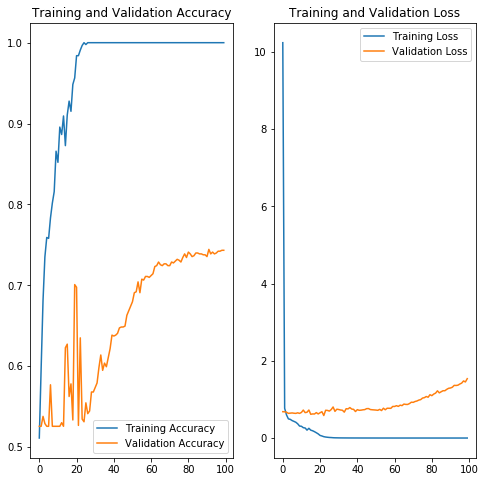

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The training accuracy and validation accuracy are off by large margin and the model has achieved only around **75%** accuracy on the validation set while the training set is well on its way to **85%**. If given more epochs, the accuracy will diverge further. So does the loss.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 75% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of *overfitting*.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. The *data augmentation* and *dropout* are popular techniques to overcome that.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. One way to fix this problem is to augment the dataset so that it has a sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training examples by augmenting them with random transformations that yield believable-looking images. The goal is the model will never see the exact same picture twice during training. This helps expose the model to more aspects of the data and generalize better.

Implement this in `tf.keras` using the `ImageDataGenerator` class. Pass  different transformations to the dataset and it will take care of applying it during the training process.

### Augment and visualize data

Begin by applying random horizontal flip augmentation to the dataset and see how individual images look like after the transformation.

### Apply horizontal flip

Pass `horizontal_flip` as an argument to the `ImageDataGenerator` class and set it to `True` to apply this augmentation.

In [20]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [21]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 1000 images belonging to 2 classes.


Take one sample image from the training examples and repeat it five times so that the augmentation is applied to the same image five times.

In [22]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

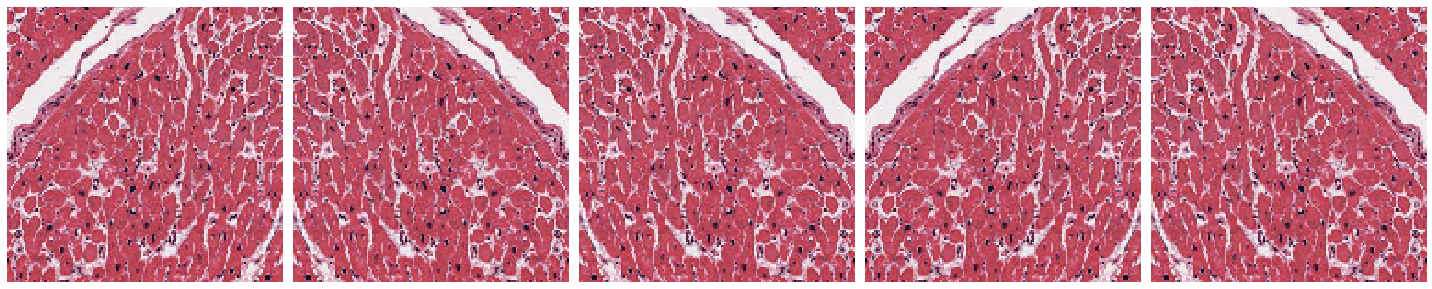

In [23]:
# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

### Randomly rotate the image

Apply 45 degrees of rotation randomly to the training samples as another augmentation.

In [24]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [25]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 1000 images belonging to 2 classes.


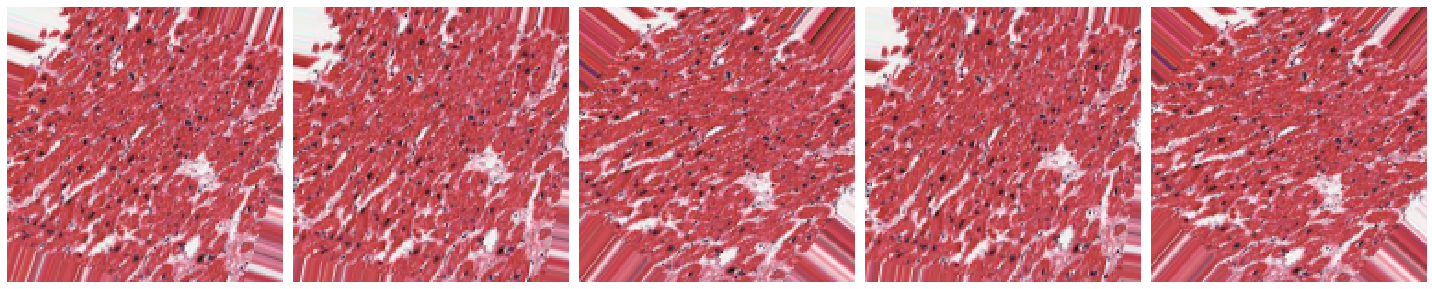

In [26]:
plotImages(augmented_images)

### Apply zoom augmentation

Apply a zoom augmentation to the dataset to zoom images up to 50% randomly.

In [27]:
# zoom_range from 0 - 1 where 1 = 100%.
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5) # 

In [28]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 1000 images belonging to 2 classes.


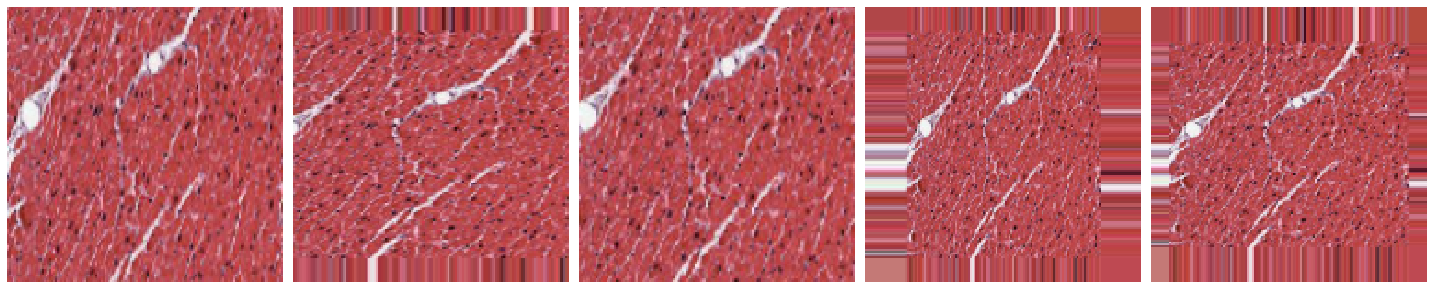

In [29]:
plotImages(augmented_images)

### Put it all together

Apply all the previous augmentations: rescale, 45 degree rotation, width shift, height shift, horizontal flip and zoom augmentation to the training images.

In [30]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [31]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 1000 images belonging to 2 classes.


Visualize how a single image would look five different times when passing these augmentations randomly to the dataset.

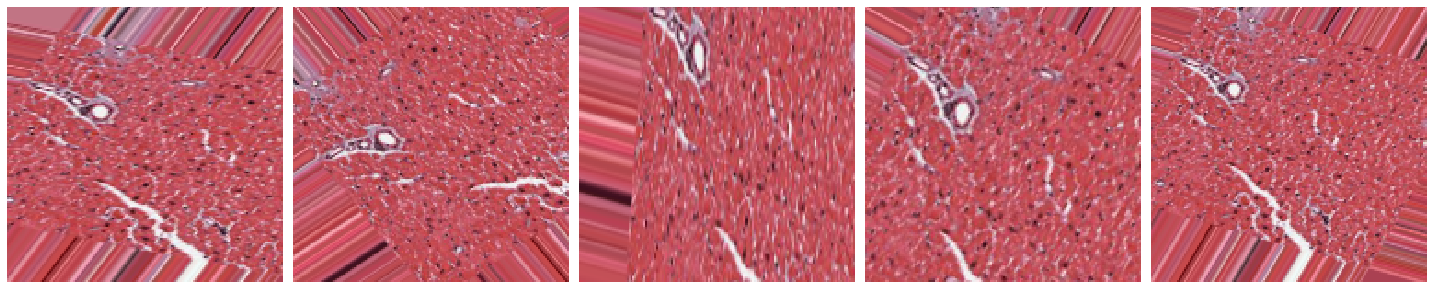

In [32]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Create validation data generator

Generally, only apply data augmentation to the training examples. In this case, only rescale the validation images and convert them into batches using `ImageDataGenerator`.

In [33]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [34]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 978 images belonging to 2 classes.


## Dropout

Another technique to reduce overfitting is to introduce *dropout* to the network. It is a form of *regularization* that forces the weights in the network to take only small values, which makes the distribution of weight values more regular and the network can reduce overfitting on small training examples. Dropout is one of the regularization technique used in multiple ML scenarios, including image classification.

When you apply dropout to a layer it randomly drops out (set to zero) number of output units from the applied layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

When appling 0.1 dropout to a certain layer, it randomly kills 10% of the output units in each training epoch.

Create a network architecture with this new dropout feature and apply it to different convolutions and fully-connected layers.

## Creating a new network with Dropouts

Apply dropout to first and last max pool layers. Applying dropout will randomly set 20% of the neurons to zero during each training epoch. This helps to avoid overfitting on the training dataset. And of course, it could also forget useful knowledge.

In [35]:
model_new = Sequential([
#     Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
#     MaxPooling2D(),
#     Dropout(0.2),
#     Conv2D(32, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Conv2D(64, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Conv2D(128, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Dropout(0.2),
#     Flatten(),
#     Dense(512, activation='relu'),
#     Dense(1)
    
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

### Compile the model

After introducing dropouts to the network, compile the model and view the layers summary.

In [36]:
model_new.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 37, 37, 256)      

### Train the model

After successfully introducing data augmentations to the training examples and adding dropouts to the network, train this new network:

In [37]:
history = model_new.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 7 steps, validate for 7 steps
Epoch 1/100
7/7 [==============================] - 9s 1s/step - loss: 5.4508 - accuracy: 0.5103 - val_loss: 1.3377 - val_accuracy: 0.5312
Epoch 2/100
7/7 [==============================] - 8s 1s/step - loss: 0.8276 - accuracy: 0.5046 - val_loss: 0.8309 - val_accuracy: 0.5312
Epoch 3/100
7/7 [==============================] - 8s 1s/step - loss: 0.6457 - accuracy: 0.5447 - val_loss: 0.7549 - val_accuracy: 0.5312
Epoch 4/100
7/7 [==============================] - 8s 1s/step - loss: 0.5388 - accuracy: 0.7064 - val_loss: 0.7053 - val_accuracy: 0.5312
Epoch 5/100
7/7 [==============================] - 8s 1s/step - loss: 0.5082 - accuracy: 0.7420 - val_loss: 0.6640 - val_accuracy: 0.5312
Epoch 6/100
7/7 [==============================] - 8s 1s/step - loss: 0.5160 - accuracy: 0.7374 - val_loss: 0.6707 - val_accuracy: 0.5312
Epoch 7/100
7/7 [==============================] - 8s 1s/step - loss: 0.4625 - acc

7/7 [==============================] - 8s 1s/step - loss: 0.2645 - accuracy: 0.8922 - val_loss: 0.4671 - val_accuracy: 0.7221
Epoch 59/100
7/7 [==============================] - 8s 1s/step - loss: 0.2900 - accuracy: 0.8658 - val_loss: 0.4848 - val_accuracy: 0.8058
Epoch 60/100
7/7 [==============================] - 8s 1s/step - loss: 0.3006 - accuracy: 0.8727 - val_loss: 0.4795 - val_accuracy: 0.8136
Epoch 61/100
7/7 [==============================] - 8s 1s/step - loss: 0.2649 - accuracy: 0.8761 - val_loss: 1.5951 - val_accuracy: 0.5413
Epoch 62/100
7/7 [==============================] - 8s 1s/step - loss: 0.2791 - accuracy: 0.8911 - val_loss: 1.4019 - val_accuracy: 0.5379
Epoch 63/100
7/7 [==============================] - 8s 1s/step - loss: 0.2549 - accuracy: 0.8807 - val_loss: 0.5753 - val_accuracy: 0.6652
Epoch 64/100
7/7 [==============================] - 8s 1s/step - loss: 0.2739 - accuracy: 0.8795 - val_loss: 3.3379 - val_accuracy: 0.5312
Epoch 65/100
7/7 [======================

### Visualize the model

Visualize the new model after training. There is significantly less overfitting than before. The accuracy suffers slightly. However, there is no divergence in either accuracy or loss in training and verification data sets.

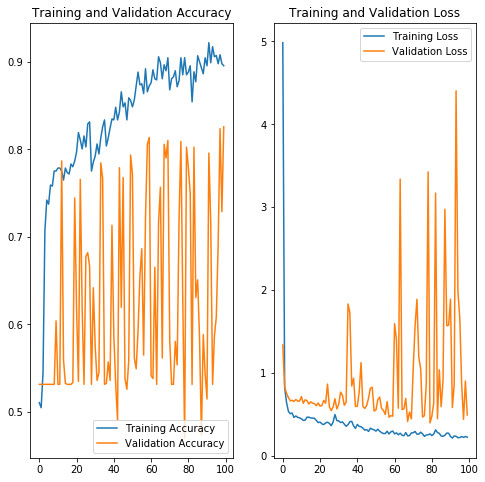

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()